# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalize it using DESeq2

In [1]:
library("fission")
data("fission")
counts <- SummarizedExperiment::assay(fission)
keep <- rowMeans(counts) >1
counts <- counts[keep,]
col_data <- fission@colData
write.csv(counts, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

wt_counts <- counts[,1:18]
wt_col_data <- col_data[1:18,]
write.csv(wt_counts, file = "wt_counts.csv")
write.csv(wt_col_data, file = "wt_col_data.csv")
dim(counts)

SyntaxError: invalid syntax (<ipython-input-1-7d2e860974d3>, line 3)

DESeq2 two samples test

In [ ]:
col_data_scaled <- read.csv(file = 'fission_col_data_scaled.csv',row.names = 1, header = TRUE)

library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data_scaled,
                              design = ~ strain + minute + strain:minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
dim(normalized_counts)
write.csv(normalized_counts, file = "fission_normalized_counts_scaled.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ strain + minute)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_tst_scaled.csv")

In [ ]:
col_data_scaled <- read.csv(file = 'wt_col_data_scaled.csv',row.names = 1, header = TRUE)

dds <- DESeqDataSetFromMatrix(countData = wt_counts,
                              colData = wt_col_data,
                              design = ~  minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
write.csv(normalized_counts, file = "wt_normalized_counts_scaled.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ 1)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_ost_scaled.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
filename = 'fission_normalized_counts_scaled.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('fission_col_data_scaled.csv',index_col=[0])
X = X[['minute']]
X

,minute
GSM1368273,0.000000
GSM1368274,0.000000
GSM1368275,0.000000
GSM1368276,0.083333
GSM1368277,0.083333
GSM1368278,0.083333
GSM1368279,0.166667
GSM1368280,0.166667
GSM1368281,0.166667
GSM1368282,0.333333


Fit some fission gene normalized data using GPcounts -- Two samples test

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    
    if model_index == 1 or model_index == 2:
        c = 'blue'
        m = 'o'

    else:
        c = 'salmon'
        m = '^'
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color='light'+c, alpha=0.2)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,alpha = 0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color='light'+c,alpha = 0.2)
        
    plt.plot(xtest, mean,color= c, lw=2, alpha=0.7) 
    
    if test == 'Two_samples_test':
        if model_index == 1:
            plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'blue', alpha=0.7) #data    
            plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='^', color= 'salmon', alpha=0.7) #data
            
            plt.show()
        else: 
            plt.scatter(model.data[0],model.data[1],s=30,marker = m, color=c, alpha=0.7)
            
            if model_index == 3:
                plt.show()
    
    else:
        plt.scatter(model.data[0],model.data[1], s=30, color= c, alpha=0.7) #data
        plt.show()

In [4]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = ['SPNCRNA.750','SPAC869.09']#,'SPBTRNAARG.07','SPNCRNA.735','SPBPB2B2.06c','SPNCRNA.554','SPAC869.06c']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

 50%|█████     | 1/2 [00:07<00:07,  7.06s/it]

local Optima
1
y_mean 10.083333333333334
mean_mean 18.776761637414584
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
1
y_mean 10.083333333333334
mean_mean 18.0272039946744
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
1
y_mean 10.083333333333334
mean_mean 20.497812569328026
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
1
y_mean 10.083333333333334
mean_mean 18.87884614185036
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
1
y_mean 10.083333333333334
mean_mean 17.938882152567874
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
2
y_mean 15.333333333333334
mean_mean 26.692578447309657
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
2
y_mean 15.333333333333334
mean_mean 26.170308746611692
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
2
y_mean 15.333333333333334
mean_mean 28.427795446476186
abs(round((mean_mean-y_mean)/y_mean)) 1.0
local Optima
2
y_mean 15.333333333333334
mean_mean 26.673942130956995
abs(round((mean_mean-y_mean)/y_mean))

100%|██████████| 2/2 [00:21<00:00, 10.85s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPNCRNA.750,-74.152538,-42.218700,-31.763184,0.170654
SPAC869.09,-107.457421,-61.254104,-45.745640,0.457677


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


SPNCRNA.750


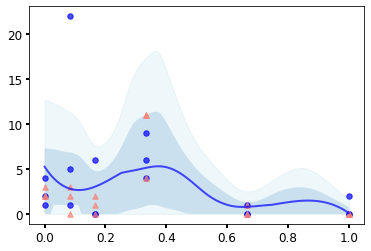

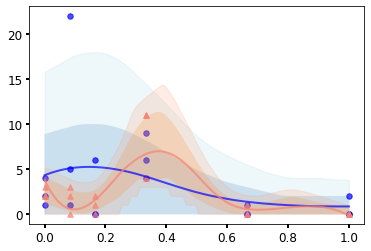

SPAC869.09


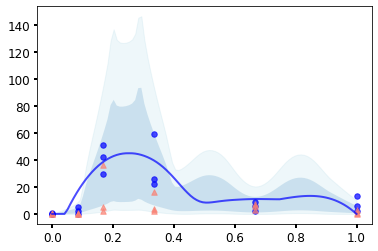

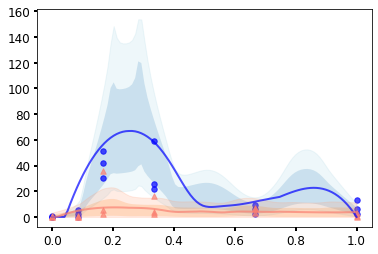

In [5]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values),np.max(X.values),100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1

In [6]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.Two_samples_test(likelihood)
log_likelihood_ratio

  0%|          | 0/2 [00:00<?, ?it/s]

Fit Cholesky decomposition was not successful.


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio
SPNCRNA.750,-42.200478,-23.430670,-16.112597,2.657210
SPAC869.09,-50.560468,-22.652707,-22.987567,4.920193


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


SPNCRNA.750


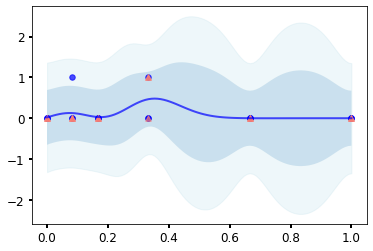

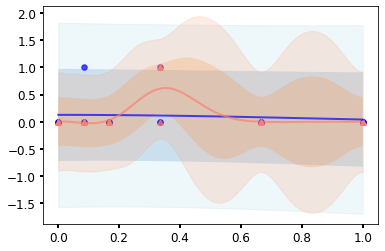

SPAC869.09


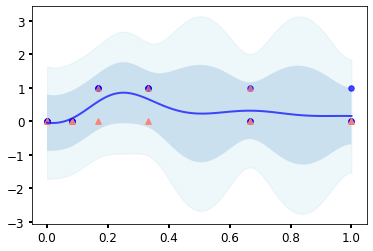

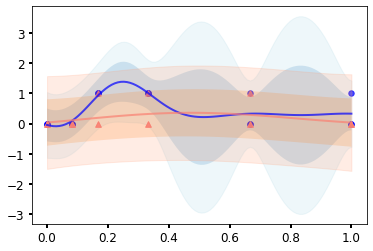

In [7]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

One Sample test

In [8]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial'
genes_name = ['SPBC2F12.09c','SPBC16E9.20','SPNCRNA.432','SPNCRNA.194','SPNCRNA.1473','SPNCRNA.1695']
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[:,0:18].loc[genes_name]) 
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
SPBC2F12.09c,-80.267537,-1550.176696,1469.909159
SPBC16E9.20,-37.358688,-42.055966,4.697278
SPNCRNA.432,-48.302304,-48.934921,0.632617
SPNCRNA.194,-34.295706,-37.512158,3.216451
SPNCRNA.1473,-67.835100,-104.545401,36.710301
SPNCRNA.1695,-51.778852,-59.254192,7.475340


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


SPBC2F12.09c


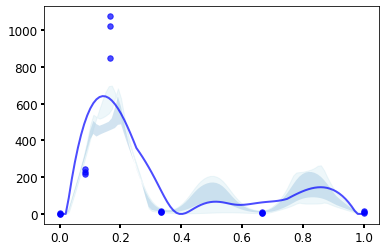

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,12.539181212204515
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.12262129785581062
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.010952540647229798
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[2.09719880e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1.07236078e-01, 0.00000000e+00, 0.00000000e+00..."


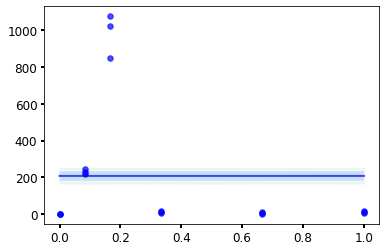

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,14.596747695605544
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.010952540647229798
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[1.39605245e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[7.75380567e-03, 0.00000000e+00, 0.00000000e+00..."


SPBC16E9.20


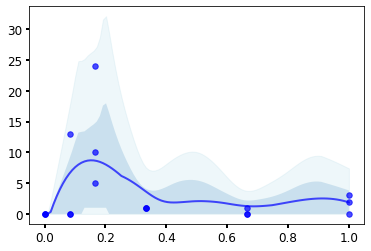

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.9888342693364136
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0715246728473484
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.4513118174715502
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[-6.35638611e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[6.87380320e-01, 0.00000000e+00, 0.00000000e+00..."


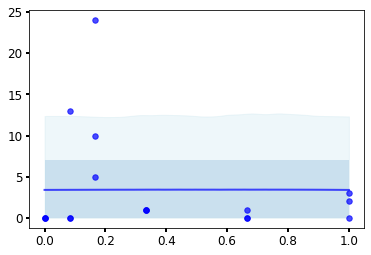

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.4625019652632585
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.4513118174715502
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.69483160e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[2.45200902e-01, 0.00000000e+00, 0.00000000e+00..."


SPNCRNA.432


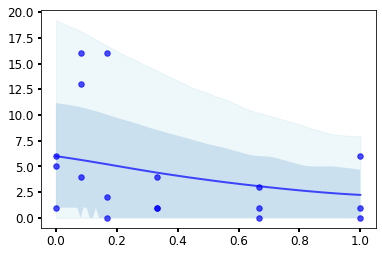

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.120926880506916
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.1625211851886434
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.0531403890994315
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[1.18880928e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[2.25698141e-01, 0.00000000e+00, 0.00000000e+00..."


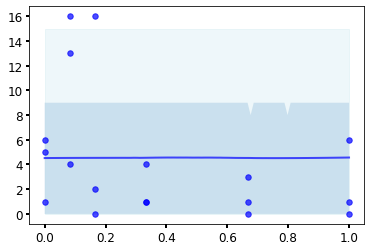

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.218288257225838
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.0531403890994315
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.84714640e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1.74464132e-01, 0.00000000e+00, 0.00000000e+00..."


SPNCRNA.194


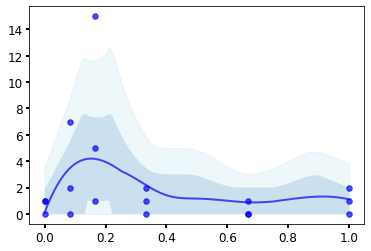

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.8570379356697528
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.09089363587729453
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.8451756242096562
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[1.39304320e-02...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[6.26420472e-01, 0.00000000e+00, 0.00000000e+00..."


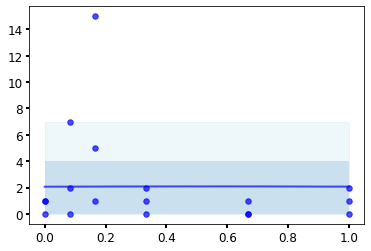

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.5385292934249569
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.8451756242096562
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.39295687e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[3.43078449e-01, 0.00000000e+00, 0.00000000e+00..."


SPNCRNA.1473


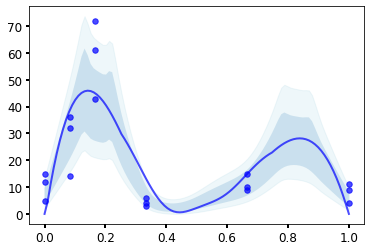

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.365135092074123
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.16147607068290867
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.08623311653342361
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.97244684e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1.01207383e-01, 0.00000000e+00, 0.00000000e+00..."


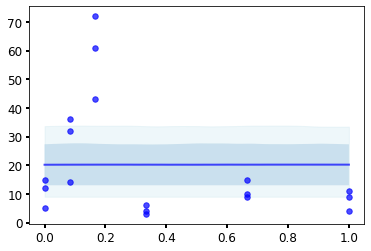

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.988800006755369
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.08623311653342361
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[0.99962912...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[2.89812369e-02, 0.00000000e+00, 0.00000000e+00..."


SPNCRNA.1695


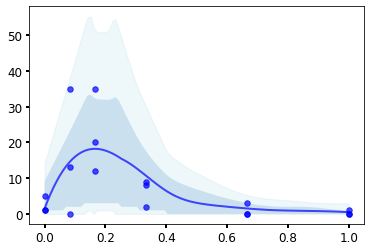

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.6954756268170095
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.18785429190089042
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.0007625764517938
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.04204534e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[3.44346722e-01, 0.00000000e+00, 0.00000000e+00..."


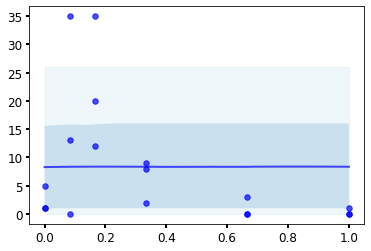

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.388649478248829
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.0007625764517938
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[9.93058667e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1.17526243e-01, 0.00000000e+00, 0.00000000e+00..."


In [9]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values),np.max(X.values),100)[:,None] # points to make prediction
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):  
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [10]:
likelihood = 'Gaussian'
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
SPBC2F12.09c,-22.147934,-41.276138,19.128204
SPBC16E9.20,-25.787924,-27.460923,1.673000
SPNCRNA.432,-25.523910,-26.013102,0.489192
SPNCRNA.194,-22.762758,-22.792723,0.029966
SPNCRNA.1473,-20.508341,-25.791921,5.283581
SPNCRNA.1695,-28.621976,-31.624478,3.002502


100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


SPBC2F12.09c


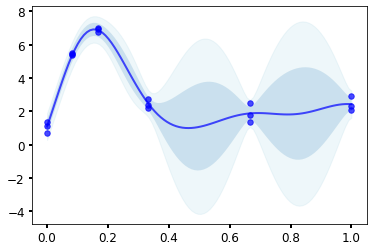

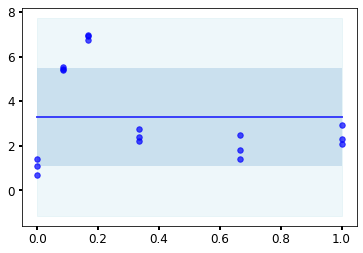

SPBC16E9.20


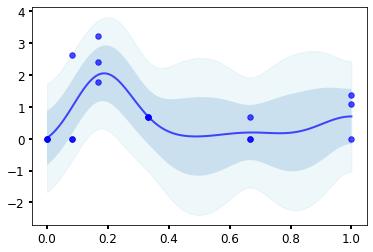

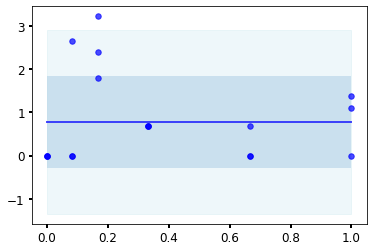

SPNCRNA.432


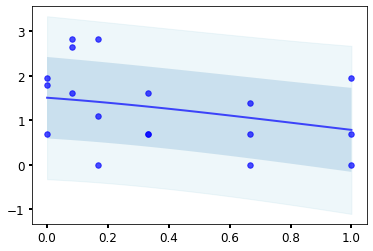

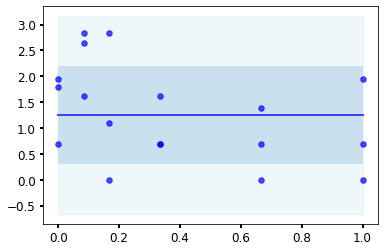

SPNCRNA.194


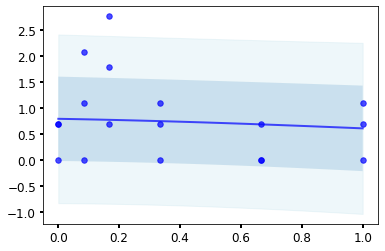

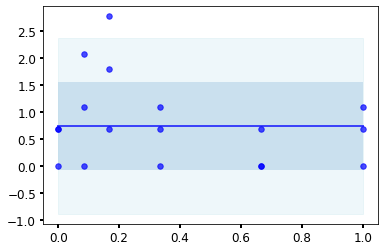

SPNCRNA.1473


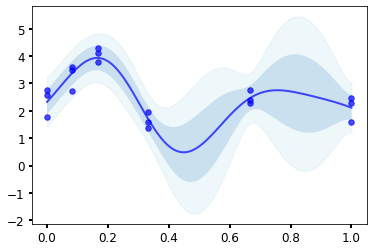

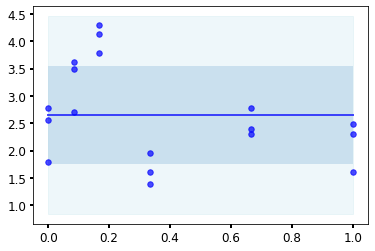

SPNCRNA.1695


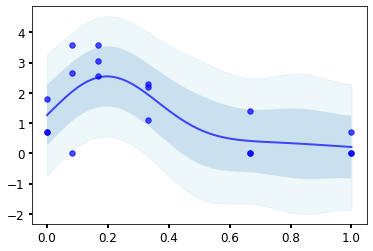

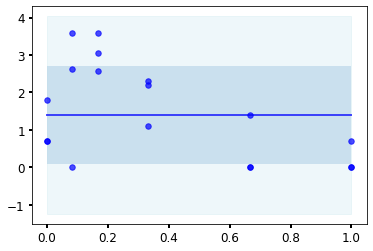

In [11]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1